In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [207]:
class Simulation:
    def __init__(self, A, initial_state, whatH):
        self.A = A
        self.initial_state = initial_state
        self.whatH = whatH
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega = sc.optimal_omegad(self.A)[0]*2*np.pi

        if self.whatH == 'H2':
            # Setup actual system
            self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 

    def H2(self):
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        # Create H_control with only specific off-diagonal elements
        H_control = self.sc.H_control.copy()
        # Zero out all elements first
        H_control[:] = 0

        # Keep only elements [0,2], [1,3], [2,4], [3,5] and their symmetric counterparts
        for i in range(len(H_control) - 2):
            # Keep the upper diagonal elements [i, i+2]
            H_control[i, i+2] = self.sc.H_control[i, i+2]
            # Make it symmetric by setting [i+2, i]
            H_control[i+2, i] = self.sc.H_control[i+2, i]

        H0 = qt.Qobj(H0) 
        H_control = qt.Qobj(H_control)
        H_rot = self.optimal_omega*np.kron(np.array([[0,0,0],[0,1,0],[0,0,2]]), np.identity(2)) + self.optimal_omega*np.kron(np.identity(3), np.array([[0,0],[0,1]])) 

        # H_rot = H0 + A/2*H_control
        H0_rot = H0.full() - H_rot+ self.A/2 * H_control.full()
        evals_rot, U = np.linalg.eigh(H0_rot)
        evals_rot, U = sort_eigenpairs(evals_rot, U)
        evals_rot = evals_rot - evals_rot[0]
        self.omega_c = evals_rot[1]
        H0 = np.diag(evals_rot)
        H0 = qt.Qobj(H0)

        Ud = U.T.conj()
        U = qt.Qobj(U)
        Ud = qt.Qobj(Ud)
        dressed00 = qt.basis(6,0)
        dressed01 = qt.basis(6,1)
        dressed10 = qt.basis(6,2)
        dressed11 = qt.basis(6,3)
        P10 = dressed10 * dressed10.dag()
        P11 = dressed11 * dressed11.dag()
        P00 = dressed00 * dressed00.dag()
        P01 = dressed01 * dressed01.dag()
        sigmaxc = qt.Qobj(np.kron(np.identity(3), np.array([[0,1],[1,0]])))
        sigmaxs = qt.Qobj(np.kron(np.array([[0,1,0],[1,0,0],[0,0,0]]), np.identity(2)))
        initial00 = dressed00
        initial01 = dressed01
        initialpc = np.sqrt(1/2)*(dressed00 + dressed01)
        initialps = np.sqrt(1/2)*(dressed00 + dressed10)
        noise = Ud@np.diag(np.diag(self.sc.noise) - np.diag(self.sc.noise)[0])@U
        self.s = np.zeros([6,6], dtype=complex)
        self.s[:4,:4] = self.sc.s[:4,:4]
        self.s = Ud@self.s@U
        
        self.s = self.s.full()
        for i in range(1,4):
            self.s[i,i] = self.s[i,i] - self.s[0,0]
        self.s[0,0] = 0
        self.s = qt.Qobj(self.s)
        noise = qt.Qobj(noise)
        if self.initial_state == '00':
            initial_state = initial00
            M = P10
        elif self.initial_state == '01':
            initial_state = initial01
            M = [P00,P01,P10,P11]
        elif self.initial_state == 'pc':
            initial_state = initialpc
            M = sigmaxc
        elif self.initial_state == 'ps':
            initial_state = initialps
            M = sigmaxs
        
        return H0, H_control , initial_state, M, noise
  
    def gaussian_ramp(self, t_rise, t_flat, t_down, amplitude):
        """
        Creates a time-dependent function using a Gaussian function that rises, 
        stays flat, and then falls.

        Args:
        t_rise (float): The time at which the function reaches the amplitude.
        t_flat (float): The duration for which the function stays at the amplitude.
        t_down (float): The time it takes for the function to fall back to zero.
        amplitude (float): The maximum amplitude of the Gaussian peak.

        Returns:
        function: A function of time 't' that implements the desired behavior.
        """
        # Define the standard deviation for the Gaussian edges
        sigma_rise = t_rise / 3  # Adjust sigma to make the function start close to zero at t=0
        sigma_down = t_down / 3  # Similar adjustment for the falling edge

        # Define the function using a closure to encapsulate the parameters
        def time_dependent_function(t):
            t_start_flat = t_rise  # Time when flat region starts
            t_end_flat = t_rise + t_flat  # Time when flat region ends
            
            if t <= t_start_flat:
                # Gaussian rise centered at t_rise
                return amplitude * np.exp(-((t - t_start_flat)**2) / (2 * sigma_rise**2)) - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))
            elif t >= t_end_flat:
                # Gaussian fall centered at t_end_flat
                return amplitude * np.exp(-((t - t_end_flat)**2) / (2 * sigma_down**2)) - amplitude * np.exp(-((t_end_flat + t_down - t_end_flat)**2) / (2 * sigma_down**2))
            else:
                # Constant amplitude in the middle region
                return amplitude - amplitude * np.exp(-((0 - t_start_flat)**2) / (2 * sigma_rise**2))

        return time_dependent_function

In [208]:
def filter_matrix_elements(matrix, indices):
    """
    Filter a matrix to keep only specified matrix elements, setting all others to zero.
    
    Args:
        matrix: Input matrix (numpy array or qutip Qobj)
        indices: List of [row, col] pairs specifying which elements to keep
                Example: [[0,0], [0,1]] keeps only elements (0,0) and (0,1)
    
    Returns:
        Filtered matrix with same type as input
    """
    # Handle qutip Qobj
    if hasattr(matrix, 'data'):
        # Create a copy of the matrix data - handle both sparse and dense formats
        if hasattr(matrix.data, 'toarray'):
            # Sparse matrix
            filtered_data = np.zeros_like(matrix.data.toarray())
        else:
            # Dense matrix or memoryview - convert to numpy array
            filtered_data = np.zeros_like(np.array(matrix.data))
        
        # Keep only specified elements
        for row, col in indices:
            if row < matrix.shape[0] and col < matrix.shape[1]:
                if hasattr(matrix.data, 'toarray'):
                    filtered_data[row, col] = matrix.data.toarray()[row, col]
                else:
                    filtered_data[row, col] = np.array(matrix.data)[row, col]
        
        # Return as qutip Qobj with same properties
        return qt.Qobj(filtered_data)
    
    # Handle numpy arrays
    else:
        filtered_matrix = np.zeros_like(matrix)
        
        # Keep only specified elements
        for row, col in indices:
            if row < matrix.shape[0] and col < matrix.shape[1]:
                filtered_matrix[row, col] = matrix[row, col]
        
        return filtered_matrix


In [232]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Define parameter ranges
options = qt.Options(rtol=1e-14, atol=1e-14)
A = 5e-3 * 2 * np.pi
gamma = 1/2e4
# T1 measurement (01 -> 00 decay)
initial_state_type = '01'
whatH = 'H2'
simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
H0, H_control, initial_state, M, noise = simulation.H2()
P00, P01, P10, P11 = M

t_list = np.linspace(0, 3000, 20000)
H = [H0]

L = np.sqrt(gamma) * qt.Qobj(simulation.s)


In [246]:
qt.Qobj(np.abs(L.full()))

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.00000000e+00 6.91949695e-04 6.68874331e-03 5.52230778e-05
  3.87581868e-04 9.93014108e-06]
 [1.05107508e-19 1.34908084e-04 4.31941028e-19 6.75564223e-03
  2.30688419e-20 3.79557328e-04]
 [3.95914695e-04 2.24827391e-05 3.25464095e-03 8.49978142e-04
  9.42732048e-05 4.60942786e-05]
 [2.32142502e-20 3.29708519e-04 9.53993417e-20 3.11979865e-03
  5.09501645e-21 8.38311870e-05]
 [3.26453888e-06 9.13765089e-06 1.34149659e-05 4.75218624e-05
  7.77335486e-07 2.65626328e-06]
 [1.97024554e-22 2.79851972e-06 8.09675625e-22 1.26646467e-05
  4.32420535e-23 7.11547369e-07]]

In [247]:
L1 = qt.Qobj(filter_matrix_elements(L.full(), [[0,1],[1,1],[2,0]]))
c_ops = [L1]

result = qt.mesolve(H, initial_state, t_list, c_ops, options=options)

avg_values_P00 = [qt.expect(P00, state) for state in result.states]

def fit1(t, T1):
    return 1 - np.exp(-t / T1)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit1, t_list, avg_values_P00)
T1_fitted = popt[0]

# T2 measurement (superposition state decay)
initial_state_type = 'pc'
simulation = Simulation(A=A, initial_state=initial_state_type, whatH=whatH)
H0, H_control, initial_state, M, noise = simulation.H2()


t_list = np.linspace(0, 2, 100)

result = qt.mesolve(H, initial_state, t_list, c_ops, options=options)
avg_values_Pxc = [qt.expect(M, state) for state in result.states]

# Fit to cosine function
def cos_fit(t, A, omega, phi):
    return A * np.cos(omega * t + phi)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(cos_fit, t_list, avg_values_Pxc, p0=[0.5, simulation.omega_c, 0])
_, freq, _ = popt


t_list = np.linspace(0, 20000, 10000)
result = qt.mesolve(H, initial_state, t_list, c_ops, options=options)
avg_values_Pxc = [qt.expect(M, state) for state in result.states]



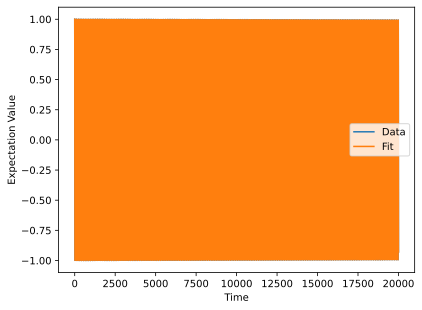

In [248]:

def T2fit(t, T2):
    return np.exp(-t / T2) * np.cos(simulation.omega_c * t)

popt, pcov = curve_fit(T2fit, t_list, avg_values_Pxc, p0=[1e6])
T2_fit = popt[0]

plt.figure()
plt.plot(t_list, avg_values_Pxc, label='Data')
plt.plot(t_list, T2fit(t_list, *popt), label='Fit')
plt.xlabel('Time')
plt.ylabel('Expectation Value')
plt.legend()
plt.show()


In [236]:
1/T2_fit - 1/T1_fitted/2

np.float64(8.751433356737874e-08)

In [249]:
1/T1_fitted

np.float64(6.331452572316008e-05)

In [244]:
np.abs(L.full())**2

array([[0.00000000e+00, 4.78794380e-07, 4.47392871e-05, 3.04958832e-09,
        1.50219704e-07, 9.86077019e-11],
       [1.10475883e-38, 1.82001911e-08, 1.86573052e-37, 4.56387019e-05,
        5.32171467e-40, 1.44063765e-07],
       [1.56748446e-07, 5.05473559e-10, 1.05926877e-05, 7.22462841e-07,
        8.88743714e-09, 2.12468252e-09],
       [5.38901413e-40, 1.08707708e-07, 9.10103440e-39, 9.73314362e-06,
        2.59591927e-41, 7.02766791e-09],
       [1.06572141e-11, 8.34966638e-11, 1.79961310e-10, 2.25832741e-09,
        6.04250458e-13, 7.05573459e-12],
       [3.88186750e-44, 7.83171260e-12, 6.55574617e-43, 1.60393276e-10,
        1.86987519e-45, 5.06299659e-13]])

In [216]:
np.abs(L2.full())**2/2

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.8374223e-08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [218]:
np.abs(L.full())**2

array([[0.00000000e+00, 4.78794380e-07, 4.47392871e-05, 3.04958832e-09,
        1.50219704e-07, 9.86077019e-11],
       [1.10475883e-38, 1.82001911e-08, 1.86573052e-37, 4.56387019e-05,
        5.32171467e-40, 1.44063765e-07],
       [1.56748446e-07, 5.05473559e-10, 1.05926877e-05, 7.22462841e-07,
        8.88743714e-09, 2.12468252e-09],
       [5.38901413e-40, 1.08707708e-07, 9.10103440e-39, 9.73314362e-06,
        2.59591927e-41, 7.02766791e-09],
       [1.06572141e-11, 8.34966638e-11, 1.79961310e-10, 2.25832741e-09,
        6.04250458e-13, 7.05573459e-12],
       [3.88186750e-44, 7.83171260e-12, 6.55574617e-43, 1.60393276e-10,
        1.86987519e-45, 5.06299659e-13]])

In [141]:
H

[Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[ 0.          0.          0.          0.          0.          0.        ]
  [ 0.         -6.05402419  0.          0.          0.          0.        ]
  [ 0.          0.         -0.13305507  0.          0.          0.        ]
  [ 0.          0.          0.         -6.1990816   0.          0.        ]
  [ 0.          0.          0.          0.         -0.89022223  0.        ]
  [ 0.          0.          0.          0.          0.         -6.97627298]]]

In [138]:
((np.abs(L.full())**2)[1,1] - (np.abs(L.full())**2)[0,0])/2

np.float64(0.0)

In [36]:
(np.abs(L.full())[1,1] - np.abs(L.full())[0,0])**2

np.float64(1.820019107248646e-08)

(0.995, 1.0)

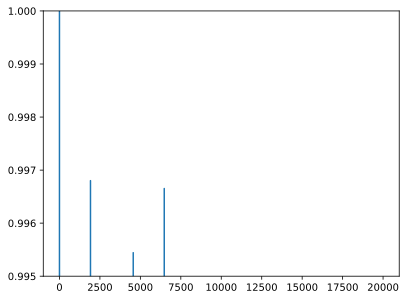

In [11]:
plt.plot(avg_values_Pxc)
# plt.plot(T2fit(t_list, *popt))
# plt.ylim(0.995, 1)